In [1]:
import Pkg
Pkg.activate("..")

# these lines are required only for local installations
Pkg.develop(path="../../scp_traj_opt/")
Pkg.precompile()

using PyPlot, Colors, LinearAlgebra

# using SCPToolbox
include("../../scp_traj_opt/src/SCPToolbox.jl")
using .SCPToolbox
using LinearAlgebra
using COSMO
using Ipopt
using SCS
using ECOS
using OSQP

Pkg.add("Gurobi")
Pkg.build("Gurobi")
using Gurobi

Pkg.add("MosekTools")
Pkg.build("MosekTools")
using MosekTools

  Activating project at `~/Documents/SCPToolbox_tutorial`
   Resolving package versions...
  No Changes to `~/Documents/SCPToolbox_tutorial/Project.toml`
  No Changes to `~/Documents/SCPToolbox_tutorial/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/SCPToolbox_tutorial/Project.toml`
  No Changes to `~/Documents/SCPToolbox_tutorial/Manifest.toml`
    Building Gurobi → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/aac05324d46b53289ccb05510b05b4a56ffd3ed5/build.log`
Precompiling project...
  ✓ Gurobi
  ✓ tutorial
  2 dependencies successfully precompiled in 3 seconds (81 already precompiled)
   Resolving package versions...
    Updating `~/Documents/SCPToolbox_tutorial/Project.toml`
  [1ec41992] + MosekTools v0.9.4
    Updating `~/Documents/SCPToolbox_tutorial/Manifest.toml`
  [6405355b] + Mosek v1.2.1
  [1ec41992] + MosekTools v0.9.4
  [1b915085] + WinReg v0.3.1
    Building Mosek → `

In [2]:
_ro = 0.35
_co = [-0.1; 1]
_carl, _carw = 0.2, 0.1

# Define the problem
pbm = TrajectoryProblem(nothing)
problem_set_dims!(pbm, 3, 2, 1)
# Initial guess
_x0 = [0; 0; 0] # Initial state
_xf = [0; 2; 0] # Terminal state
problem_set_guess!(
    pbm, (N, pbm) -> begin
        x = straightline_interpolate(_x0, _xf, N)
        idle = zeros(pbm.nu)
        u = straightline_interpolate(idle, idle, N)
        p = zeros(pbm.np)
        return x, u, p
    end)
# Cost function
problem_set_running_cost!(
    pbm, :ptr, (t, k, x, u, p, pbm) -> u'*u)
# Dynamics
_tf = 3
problem_set_dynamics!(
    pbm,
    # f
    (t, k, x, u, p, pbm) ->
        [u[1]*sin(x[3]);
         u[1]*cos(x[3]);
         u[2]]*_tf,
    # df/dx
    (t, k, x, u, p, pbm) ->
        [0 0 u[1]*cos(x[3]);
         0 0 -u[1]*sin(x[3]);
         0 0 0]*_tf,
    # df/du
    (t, k, x, u, p, pbm) ->
        [sin(x[3]) 0;
         cos(x[3]) 0;
         0 1]*_tf,
    # df/dp
    (t, k, x, u, p, pbm) ->
        zeros(pbm.nx, pbm.np))
# Obstacle constraint
problem_set_s!(
    pbm, :ptr,
    # s
    (t, k, x, u, p, pbm) -> [(_ro+_carw/2)^2-(x[1]-_co[1])^2-(x[2]-_co[2])^2],
    # ds/dx
    (t, k, x, u, p, pbm) -> collect([-2*(x[1]-_co[1]); -2*(x[2]-_co[2]); 0]'),
    # ds/du
    (t, k, x, u, p, pbm) -> zeros(1, pbm.nu),
    # ds/dp
    (t, k, x, u, p, pbm) -> zeros(1, pbm.np))
# Boundary conditions
problem_set_bc!(
    pbm, :ic, # Initial condition
    (x, p, pbm) -> x-_x0,
    (x, p, pbm) -> I(pbm.nx))
problem_set_bc!(
    pbm, :tc,  # Terminal condition
    (x, p, pbm) -> x-_xf,
    (x, p, pbm) -> I(pbm.nx))
# Define the SCP algorithm parameters
N, Nsub = 11, 10
iter_max = 30
disc_method = FOH
wvc, wtr = 1e3, 1e0
feas_tol = 5e-3
ε_abs, ε_rel = 1e-5, 1e-3
q_tr = Inf
q_exit = Inf
# solver, options = ECOS, Dict("verbose"=>0)       # works
# solver, options = Gurobi, Dict("OutputFlag"=>0)  # works
# solver, options = OSQP, Dict("verbose"=>0)       # works
solver, options = Mosek, Dict("MSK_IPAR_LOG"=>0)
# solver, options = Ipopt, Dict()                  # doesn't work
# solver, options = COSMO, Dict()                  # doesn't work
# solver, options = SCS, Dict()                    # doesn't work
pars = PTR.Parameters(
    N, Nsub, iter_max, disc_method, wvc, wtr, ε_abs,
    ε_rel, feas_tol, q_tr, q_exit, solver, options)
# Create and solve the problem
ptr_pbm = PTR.create(pars, pbm)
sol, history = PTR.solve(ptr_pbm);

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | OPTIMAL  | 8e-09 | 1e-01 | 0e+00 | 1.66e+01  |           | 3e-01 | 2e+00 | 0e+00 | 3e-01 | T   | 0.28  | 2.08  | 0.00 
2  | OPTIMAL  | 3e-11 | 3e-11 | 3e-11 | 8.40e+00  | 49.35     | 1e+00 | 5e+00 | 0e+00 | 1e+00 | F   | 1.29  | 5.17  | 0.00 
3  | OPTIMAL  | 7e-10 | 4e-10 | 6e-10 | 2.69e+00  | 67.91     | 8e-01 | 4e+00 | 0e+00 | 8e-01 | F   | 0.85  | 4.12  | 0.00 
4  | OPTIMAL  | 9e-09 | 5e-09 | 8e-09 | 1.13e+00  | 58.12     | 1e-01 | 3e-01 | 0e+00 | 1e-01 | T   | 0.12  | 0.33  | 0.00 
5  | OPTIMAL  | 9e-09 | 5e-09 | 8e-09 | 9.84e-01  | 12.76     | 1e-02 | 5e-02 | 0e+00 | 1e-02 | T   | 0.01  | 0.05  | 0.00 
6  | OPTIMAL  | 1e-08 | 7e-09 | 1e-08 | 9.54e-01  | 3.06      | 4e-04 | 2e-03 | 0e+00 | 4e-04 | T   | 0.00  | 0.00  | 0.00 
7  | OPT

In [3]:
function set_fonts()::Nothing
    # Set the figure fonts.
    fig_small_sz = 12
    fig_med_sz = 15
    fig_big_sz = 17
    plt.rc("text", usetex=true)
    plt.rc("font", size=fig_small_sz, family="serif")
    plt.rc("axes", titlesize=fig_small_sz)
    plt.rc("axes", labelsize=fig_med_sz)
    plt.rc("xtick", labelsize=fig_small_sz)
    plt.rc("ytick", labelsize=fig_small_sz)
    plt.rc("legend", fontsize=fig_small_sz)
    plt.rc("figure", titlesize=fig_big_sz)
    plt.rc("figure", dpi=300) 
    return nothing
end
;

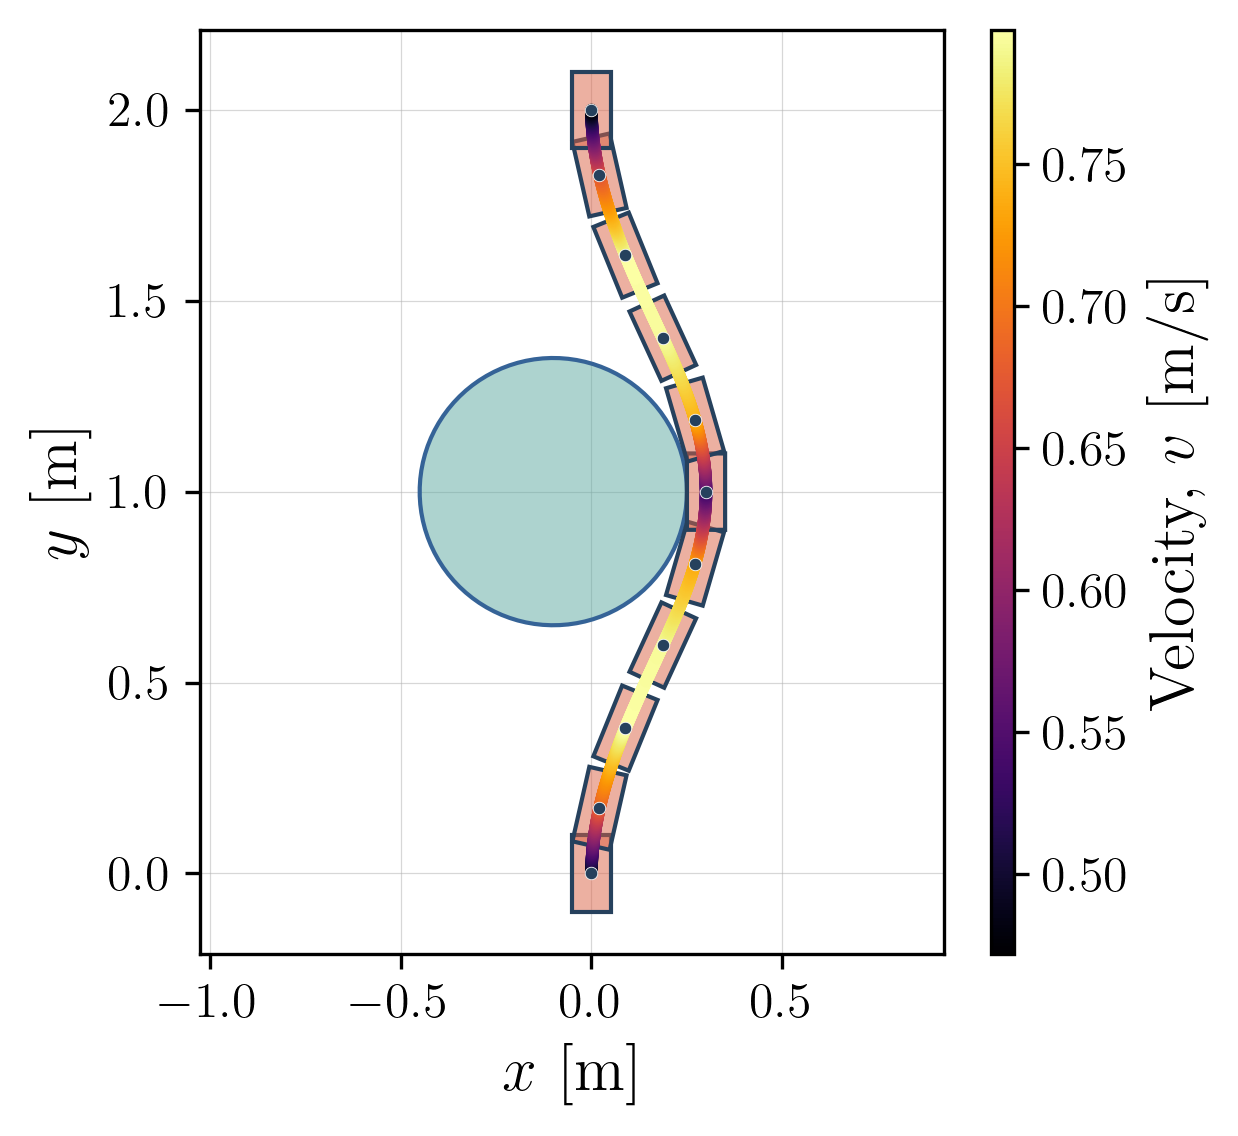

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/purnanandelango/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.patches.Polygon object at 0x7f93ad3bd6a0>

In [4]:
# Trajectory plot
ctres, overlap = 1000, 3
N = size(sol.xd, 2)
xct = hcat([sample(sol.xc, t) for t in LinRange(0, 1, ctres)]...)
vct = vcat([sample(sol.uc, t)[1] for t in LinRange(0, 1, ctres)]...)
cmap = generate_colormap("inferno"; minval=minimum(vct), maxval=maximum(vct))

# plot_options = Dict("xtick.labelsize"=>9,
#                     "ytick.labelsize"=>9,
#                     "axes.labelsize"=>11)
# fig = create_figure((4, 4); options = plot_options)

fig = plt.figure(figsize=(4,4), dpi=300)
plt.clf()
set_fonts()
set_fonts()

ax = setup_axis!(111, xlabel="\$x\$ [m]", ylabel="\$y\$ [m]",
                 axis="equal", cbar=cmap, clabel="Velocity, \$v\$ [m/s]",
                 cbar_aspect=40)
ax.plot(sol.xd[1, :], sol.xd[2, :],
        linestyle="none", marker="o", markerfacecolor=DarkBlue,
        markeredgecolor="white", markeredgewidth=0.2, markersize=3,
        zorder=20)
line_segs = Vector{Matrix}(undef, 0)
line_clrs = Vector{NTuple{4, Real}}(undef, 0)
for k=1:ctres-overlap
    push!(line_segs, xct[1:2, k:k+overlap]')
    push!(line_clrs, cmap.to_rgba(vct[k]))
end
trajectory = PyPlot.matplotlib.collections.LineCollection(
    line_segs, zorder=10, colors = line_clrs, linewidths=3,
    capstyle="round")
ax.add_collection(trajectory)
Rect = PyPlot.matplotlib.patches.Rectangle
for k=1:N
    local xl, xw = [1;1;-1;-1;1]*_carl/2, [1;-1;-1;1;1]*_carw/2
    local yl, yw = [1;1;-1;-1;1]*_carl/2, [-1;1;1;-1;-1]*_carw/2
    local ang = sol.xd[3,k]
    local xc = sol.xd[1,k].+xl.*sin(ang).+xw.*cos(ang)
    local yc = sol.xd[2,k].+yl.*cos(ang).+yw.*sin(ang)
    ax.fill(xc, yc,
            linewidth=1,
            edgecolor=DarkBlue,
            facecolor=rgb2pyplot(parse(RGB, Red), a=0.5),
            zorder=6)
end
ang = LinRange(0, 2*pi, 100)
obs = ([cos.(ang)'; sin.(ang)']*_ro).+_co
ax.fill(obs[1, :], obs[2, :],
        linewidth=1,
        edgecolor=Blue,
        facecolor=rgb2pyplot(parse(RGB, Green), a=0.5),
        zorder=5)
# save_figure("../figures/dubin_trajectory.pdf")